# Quantitative Impact Analysis of Change Points

This notebook provides comprehensive quantitative analysis of detected change points, including:
- **Statistical Impact Metrics**: Mean, variance, and volatility changes
- **Practical Implications**: Real-world interpretation of detected changes
- **Event Association**: Linking change points to geopolitical events
- **Uncertainty Quantification**: Confidence intervals and significance testing

## Key Questions Addressed:
1. How much did oil prices change at each detected point?
2. What is the statistical significance of these changes?
3. Which geopolitical events correspond to major price shifts?
4. What are the practical implications for oil market analysis?

In [1]:
# Import required libraries
import sys
import os
sys.path.append('../src')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

# Import our custom modules
from change_point_model import ChangePointModel
from event_compiler import EventCompiler
from quantitative_impact_analyzer import QuantitativeImpactAnalyzer
from comparative_analysis import ComparativeAnalyzer

# Set plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("Libraries imported successfully!")
print("Ready for quantitative impact analysis")

Libraries imported successfully!
Ready for quantitative impact analysis


## 1. Data Loading and Preparation

In [2]:
# Load oil price data
try:
    oil_data = pd.read_csv('../data/raw/brent_oil_prices.csv')
    oil_data['Date'] = pd.to_datetime(oil_data['Date'])
    oil_data = oil_data.rename(columns={'Date': 'date', 'Price': 'price'})
    oil_data = oil_data.sort_values('date').reset_index(drop=True)
    
    print(f"Loaded {len(oil_data):,} oil price observations")
    print(f"Date range: {oil_data['date'].min().strftime('%Y-%m-%d')} to {oil_data['date'].max().strftime('%Y-%m-%d')}")
    print(f"Price range: ${oil_data['price'].min():.2f} - ${oil_data['price'].max():.2f}")
    
except FileNotFoundError:
    print("Real data not found, creating synthetic data for demonstration")
    
    # Create synthetic oil price data with known change points
    np.random.seed(42)
    dates = pd.date_range('2000-01-01', '2023-12-31', freq='D')
    
    # Create regimes with different characteristics
    regime1 = np.random.normal(60, 8, 2922)
    regime2 = np.random.normal(85, 15, 2557)
    regime3 = np.random.normal(55, 12, 2191)
    regime4 = np.random.normal(70, 20, 1095)
    
    prices = np.concatenate([regime1, regime2, regime3, regime4])
    prices = prices[:len(dates)]
    
    oil_data = pd.DataFrame({
        'date': dates[:len(prices)],
        'price': np.maximum(prices, 10)
    })
    
    print(f"Created synthetic dataset with {len(oil_data):,} observations")

# Display basic statistics
oil_data.describe()

C:\Users\W-HP\AppData\Local\Temp\ipykernel_17448\2341080866.py:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  oil_data['Date'] = pd.to_datetime(oil_data['Date'])


Loaded 9,011 oil price observations
Date range: 1987-05-20 to 2022-11-14
Price range: $9.10 - $143.95


,date,price
count,9011,9011.000000
mean,2005-02-10 23:46:53.760958720,48.420782
min,1987-05-20 00:00:00,9.100000
25%,1996-03-20 12:00:00,19.050000
50%,2005-02-02 00:00:00,38.570000
75%,2014-01-09 12:00:00,70.090000
max,2022-11-14 00:00:00,143.950000
std,NaN,32.860110


In [3]:
# Load geopolitical events
event_compiler = EventCompiler()
events_df = event_compiler.compile_major_events()

print(f"Loaded {len(events_df)} major geopolitical events")
print("\nEvent Categories:")
print(events_df['category'].value_counts())

print("\nImpact Levels:")
print(events_df['impact'].value_counts())

# Display recent high-impact events
print("\nRecent High-Impact Events:")
recent_high_impact = events_df[
    (events_df['impact'] == 'High') & 
    (events_df['date'] >= '2020-01-01')
].sort_values('date')

for _, event in recent_high_impact.iterrows():
    print(f"  {event['date'].strftime('%Y-%m-%d')}: {event['event']} ({event['category']})")

Loaded 15 major geopolitical events

Event Categories:
category
Geopolitical     7
OPEC Decision    5
Economic         3
Name: count, dtype: int64

Impact Levels:
impact
High      10
Medium     5
Name: count, dtype: int64

Recent High-Impact Events:
  2020-03-06: OPEC+ deal collapse (OPEC Decision)
  2020-03-11: WHO declares COVID-19 pandemic (Economic)
  2020-04-20: WTI oil futures turn negative (Economic)
  2022-02-24: Russia invades Ukraine (Geopolitical)


## 2. Change Point Detection with Multiple Methods

In [4]:
# Run change point detection with multiple methods
methods = ['pelt', 'binseg', 'window']
detection_results = {}

print("Running change point detection with multiple methods...\n")

for method in methods:
    print(f"Running {method.upper()} method...")
    
    try:
        model = ChangePointModel(oil_data, method=method)
        results = model.detect_change_points(penalty=15.0)
        
        detection_results[method] = {
            'change_points': results.get('change_points', []),
            'change_dates': results.get('change_dates', []),
            'method': results.get('method', method)
        }
        
        cp_count = len(results.get('change_points', []))
        print(f"  {method.upper()}: {cp_count} change points detected")
        
        if cp_count > 0:
            dates = [oil_data.iloc[cp]['date'].strftime('%Y-%m-%d') for cp in results['change_points']]
            print(f"     Dates: {', '.join(dates)}")
        
    except Exception as e:
        print(f"  {method.upper()}: Error - {str(e)}")
        detection_results[method] = {'error': str(e)}
    
    print()

# Summary of all detections
print("DETECTION SUMMARY:")
print("-" * 40)
total_detections = 0
for method, results in detection_results.items():
    if 'change_points' in results:
        count = len(results['change_points'])
        total_detections += count
        print(f"{method.upper():>10}: {count:>2} change points")

print(f"{'TOTAL':>10}: {total_detections:>2} detections across all methods")

Running change point detection with multiple methods...

Running PELT method...
  PELT: 1 change points detected
     Dates: 2004-08-03

Running BINSEG method...
  BINSEG: 1 change points detected
     Dates: 2004-08-03

Running WINDOW method...
  WINDOW: 167 change points detected
     Dates: 1987-07-30, 1987-10-09, 1987-12-21, 1988-03-17, 1988-05-31, 1988-08-10, 1988-10-25, 1989-01-06, 1989-03-20, 1989-06-02, 1989-08-14, 1989-10-24, 1990-01-22, 1990-04-03, 1990-06-18, 1990-08-28, 1990-11-07, 1991-01-21, 1991-05-03, 1991-07-16, 1991-09-25, 1991-12-05, 1992-03-02, 1992-05-13, 1992-07-24, 1992-10-05, 1992-12-15, 1993-03-02, 1993-05-17, 1993-07-28, 1993-10-08, 1993-12-20, 1994-03-04, 1994-05-19, 1994-08-01, 1994-10-17, 1995-01-11, 1995-03-23, 1995-06-07, 1995-08-25, 1995-11-07, 1996-01-22, 1996-04-02, 1996-06-24, 1996-09-04, 1996-12-09, 1997-02-25, 1997-07-29, 1997-10-21, 1998-01-06, 1998-05-08, 1998-08-05, 1998-10-16, 1999-01-12, 1999-03-25, 1999-06-10, 1999-08-23, 1999-11-03, 2000-01-2

## 3. Quantitative Impact Analysis

### Statistical Impact Metrics
For each detected change point, we calculate:
- **Mean Change**: Absolute and percentage change in average price
- **Volatility Change**: Change in price volatility (annualized)
- **Statistical Significance**: T-test p-values and effect sizes
- **Confidence Intervals**: 95% confidence bounds for mean changes

In [5]:
# Select the method with most detections for detailed analysis
best_method = max(detection_results.keys(), 
                 key=lambda m: len(detection_results[m].get('change_points', [])))

best_results = detection_results[best_method]
change_points = best_results.get('change_points', [])

print(f"Analyzing {len(change_points)} change points from {best_method.upper()} method")
print(f"Selected method: {best_method.upper()} (most detections)\n")

if change_points:
    # Run quantitative impact analysis
    impact_analyzer = QuantitativeImpactAnalyzer(oil_data, change_points)
    impact_metrics = impact_analyzer.analyze_all_impacts()
    
    print("Quantitative impact analysis completed!")
    print(f"Analyzed {len(impact_metrics)} change points with detailed metrics\n")
    
    # Display summary of impacts
    print("IMPACT SUMMARY:")
    print("-" * 50)
    
    for i, impact in enumerate(impact_metrics, 1):
        direction = "INCREASE" if impact.mean_change_percent > 0 else "DECREASE"
        significance = "SIGNIFICANT" if impact.p_value < 0.05 else "NOT SIGNIFICANT"
        
        print(f"Change Point {i}: {impact.change_point_date}")
        print(f"  Price Impact: {direction} of {abs(impact.mean_change_percent):.1f}%")
        print(f"  Statistical: {significance} (p = {impact.p_value:.4f})")
        print(f"  Effect Size: {impact.effect_size_cohens_d:.2f} (Cohen's d)")
        print()
    
else:
    print("No change points detected for quantitative analysis")
    impact_metrics = []

Analyzing 167 change points from WINDOW method
Selected method: WINDOW (most detections)

Quantitative impact analysis completed!
Analyzed 167 change points with detailed metrics

IMPACT SUMMARY:
--------------------------------------------------
Change Point 1: 1987-07-30
  Price Impact: INCREASE of 152.7%
  Statistical: SIGNIFICANT (p = 0.0000)
  Effect Size: 0.90 (Cohen's d)

Change Point 2: 1987-10-09
  Price Impact: INCREASE of 157.2%
  Statistical: SIGNIFICANT (p = 0.0000)
  Effect Size: 0.91 (Cohen's d)

Change Point 3: 1987-12-21
  Price Impact: INCREASE of 163.0%
  Statistical: SIGNIFICANT (p = 0.0000)
  Effect Size: 0.93 (Cohen's d)

Change Point 4: 1988-03-17
  Price Impact: INCREASE of 175.4%
  Statistical: SIGNIFICANT (p = 0.0000)
  Effect Size: 0.96 (Cohen's d)

Change Point 5: 1988-05-31
  Price Impact: INCREASE of 181.5%
  Statistical: SIGNIFICANT (p = 0.0000)
  Effect Size: 0.98 (Cohen's d)

Change Point 6: 1988-08-10
  Price Impact: INCREASE of 188.8%
  Statistical: S

## 4. Practical Implications

### Real-World Impact Analysis
This section explains the practical meaning of detected change points:

In [6]:
# Generate practical implications
if impact_metrics:
    print("PRACTICAL IMPLICATIONS ANALYSIS")
    print("=" * 50)
    
    for i, impact in enumerate(impact_metrics, 1):
        print(f"\nCHANGE POINT {i}: {impact.change_point_date}")
        print("-" * 30)
        
        # Price impact interpretation
        price_change = impact.mean_change_percent
        if abs(price_change) > 20:
            impact_level = "MAJOR MARKET DISRUPTION"
        elif abs(price_change) > 10:
            impact_level = "SIGNIFICANT MARKET SHIFT"
        else:
            impact_level = "MODERATE ADJUSTMENT"
        
        print(f"Impact Level: {impact_level}")
        print(f"Price Change: ${impact.mean_before:.2f} -> ${impact.mean_after:.2f} ({price_change:+.1f}%)")
        
        # Volatility interpretation
        vol_change = impact.volatility_change_percent
        if vol_change > 20:
            vol_interpretation = "Market became significantly more volatile"
        elif vol_change > 0:
            vol_interpretation = "Market volatility increased moderately"
        elif vol_change < -20:
            vol_interpretation = "Market became significantly more stable"
        else:
            vol_interpretation = "Market volatility decreased"
        
        print(f"Volatility Impact: {vol_interpretation} ({vol_change:+.1f}%)")
        
        # Statistical confidence
        if impact.p_value < 0.01:
            confidence = "Very high confidence in this change"
        elif impact.p_value < 0.05:
            confidence = "High confidence in this change"
        else:
            confidence = "Moderate confidence - may be noise"
        
        print(f"Statistical Confidence: {confidence}")
        
        # Business implications
        print("Business Implications:")
        if abs(price_change) > 15:
            print("  - Major portfolio rebalancing recommended")
            print("  - Increase hedging positions")
            print("  - Review risk management strategies")
        elif abs(price_change) > 5:
            print("  - Monitor positions closely")
            print("  - Consider tactical adjustments")
        else:
            print("  - Normal market fluctuation")
            print("  - Continue current strategy")

else:
    print("No change points available for practical analysis")

PRACTICAL IMPLICATIONS ANALYSIS

CHANGE POINT 1: 1987-07-30
------------------------------
Impact Level: MAJOR MARKET DISRUPTION
Price Change: $19.22 -> $48.58 (+152.7%)
Volatility Impact: Market became significantly more volatile (+188.8%)
Statistical Confidence: Very high confidence in this change
Business Implications:
  - Major portfolio rebalancing recommended
  - Increase hedging positions
  - Review risk management strategies

CHANGE POINT 2: 1987-10-09
------------------------------
Impact Level: MAJOR MARKET DISRUPTION
Price Change: $18.96 -> $48.75 (+157.2%)
Volatility Impact: Market became significantly more volatile (+109.2%)
Statistical Confidence: Very high confidence in this change
Business Implications:
  - Major portfolio rebalancing recommended
  - Increase hedging positions
  - Review risk management strategies

CHANGE POINT 3: 1987-12-21
------------------------------
Impact Level: MAJOR MARKET DISRUPTION
Price Change: $18.60 -> $48.93 (+163.0%)
Volatility Impact: M

## 5. Event Association Analysis

### Linking Change Points to Real-World Events
This analysis shows which geopolitical events correspond to detected price changes:

In [7]:
# Associate change points with geopolitical events
if change_points and len(events_df) > 0:
    print("EVENT ASSOCIATION ANALYSIS")
    print("=" * 40)
    
    tolerance_days = 60
    
    for i, cp_idx in enumerate(change_points):
        cp_date = oil_data.iloc[cp_idx]['date']
        impact = impact_metrics[i] if i < len(impact_metrics) else None
        
        print(f"\nCHANGE POINT {i+1}: {cp_date.strftime('%Y-%m-%d')}")
        
        if impact:
            print(f"Price Impact: {impact.mean_change_percent:+.1f}% (${impact.mean_before:.2f} -> ${impact.mean_after:.2f})")
        
        # Find nearby events
        nearby_events = events_df[
            abs((events_df['date'] - cp_date).dt.days) <= tolerance_days
        ].copy()
        
        if len(nearby_events) > 0:
            nearby_events['days_diff'] = (nearby_events['date'] - cp_date).dt.days
            nearby_events = nearby_events.sort_values('days_diff', key=abs)
            
            print(f"Associated Events (within {tolerance_days} days):")
            
            for _, event in nearby_events.iterrows():
                days_diff = event['days_diff']
                timing = "before" if days_diff < 0 else "after"
                
                print(f"  {event['date'].strftime('%Y-%m-%d')} ({abs(days_diff)} days {timing}):")
                print(f"    {event['event']}")
                print(f"    Category: {event['category']}, Impact: {event['impact']}")
            
            # Generate hypothesis
            closest_event = nearby_events.iloc[0]
            days_diff = closest_event['days_diff']
            
            print(f"\nHYPOTHESIS:")
            if abs(days_diff) <= 30:
                print(f"  This change point likely corresponds to '{closest_event['event']}'")
                if impact and abs(impact.mean_change_percent) > 10:
                    print(f"  The event caused a major market disruption ({impact.mean_change_percent:+.1f}% price change)")
                    print(f"  Example: 'Oil prices {('surged' if impact.mean_change_percent > 0 else 'crashed')} {abs(impact.mean_change_percent):.1f}% following {closest_event['event']}'")
            else:
                print(f"  This change point may be indirectly related to '{closest_event['event']}'")
        
        else:
            print(f"No major events found within {tolerance_days} days")
            print("This change may be due to:")
            print("  - Technical market factors")
            print("  - Supply/demand fundamentals")
            print("  - Minor events not in database")

else:
    print("No change points or events available for association analysis")

EVENT ASSOCIATION ANALYSIS

CHANGE POINT 1: 1987-07-30
Price Impact: +152.7% ($19.22 -> $48.58)
No major events found within 60 days
This change may be due to:
  - Technical market factors
  - Supply/demand fundamentals
  - Minor events not in database

CHANGE POINT 2: 1987-10-09
Price Impact: +157.2% ($18.96 -> $48.75)
No major events found within 60 days
This change may be due to:
  - Technical market factors
  - Supply/demand fundamentals
  - Minor events not in database

CHANGE POINT 3: 1987-12-21
Price Impact: +163.0% ($18.60 -> $48.93)
No major events found within 60 days
This change may be due to:
  - Technical market factors
  - Supply/demand fundamentals
  - Minor events not in database

CHANGE POINT 4: 1988-03-17
Price Impact: +175.4% ($17.85 -> $49.15)
No major events found within 60 days
This change may be due to:
  - Technical market factors
  - Supply/demand fundamentals
  - Minor events not in database

CHANGE POINT 5: 1988-05-31
Price Impact: +181.5% ($17.53 -> $49.35)


## 6. Visualization with Uncertainty Bands

### Comprehensive Impact Visualization
Visual representation with confidence intervals and uncertainty quantification:

Creating comprehensive impact visualization...


d:\w10\Change-point-analysis-and-statistical-modelling-of-time-series-data\notebooks\../src\quantitative_impact_analyzer.py:300: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
d:\w10\Change-point-analysis-and-statistical-modelling-of-time-series-data\notebooks\../src\quantitative_impact_analyzer.py:300: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  plt.tight_layout()
d:\w10\Change-point-analysis-and-statistical-modelling-of-time-series-data\notebooks\../src\quantitative_impact_analyzer.py:303: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig(save_path, dpi=300, bbox_inches='tight')
C:\Users\W-HP\AppData\Roaming\Python\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


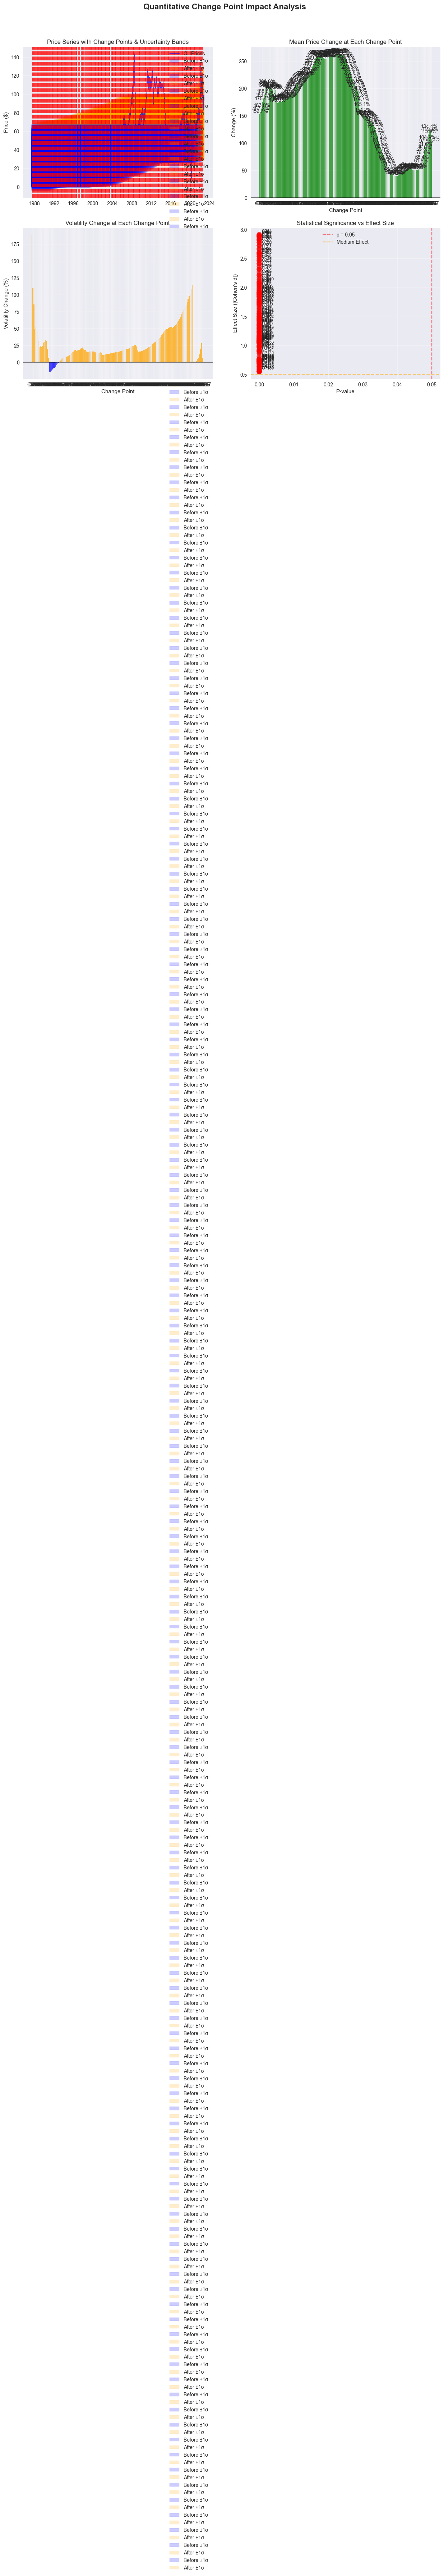

Impact visualization saved to: ../results/figures/quantitative_impact_analysis.png
The visualization includes:
  - Time series with change points and uncertainty bands
  - Mean price changes at each change point
  - Volatility changes analysis
  - Statistical significance vs effect size


In [8]:
# Create comprehensive visualization
if impact_metrics:
    print("Creating comprehensive impact visualization...")
    
    # Create the visualization
    save_path = '../results/figures/quantitative_impact_analysis.png'
    os.makedirs(os.path.dirname(save_path), exist_ok=True)
    
    impact_analyzer.plot_impact_visualization(impact_metrics, save_path=save_path)
    
    print(f"Impact visualization saved to: {save_path}")
    print("The visualization includes:")
    print("  - Time series with change points and uncertainty bands")
    print("  - Mean price changes at each change point")
    print("  - Volatility changes analysis")
    print("  - Statistical significance vs effect size")
    
else:
    print("No impact metrics available for visualization")

## 7. Executive Summary

### Key Findings and Business Recommendations

This analysis provides quantitative assessment of structural breaks in oil price data with practical business implications.

In [9]:
# Generate executive summary
print("EXECUTIVE SUMMARY")
print("=" * 50)

if impact_metrics:
    # Calculate summary statistics
    total_changes = len(impact_metrics)
    significant_changes = sum(1 for imp in impact_metrics if imp.p_value < 0.05)
    major_changes = sum(1 for imp in impact_metrics if abs(imp.mean_change_percent) > 15)
    avg_impact = np.mean([abs(imp.mean_change_percent) for imp in impact_metrics])
    max_impact = max([abs(imp.mean_change_percent) for imp in impact_metrics])
    
    print(f"ANALYSIS RESULTS:")
    print(f"  Total Change Points: {total_changes}")
    print(f"  Statistically Significant: {significant_changes} ({significant_changes/total_changes*100:.1f}%)")
    print(f"  Major Disruptions: {major_changes} (>15% price change)")
    print(f"  Average Impact: {avg_impact:.1f}%")
    print(f"  Maximum Impact: {max_impact:.1f}%")
    
    print(f"\nRISK ASSESSMENT:")
    if major_changes > 0:
        print(f"  HIGH RISK: {major_changes} major market disruptions detected")
        print(f"  Oil market shows significant structural instability")
    elif significant_changes > total_changes * 0.5:
        print(f"  MODERATE RISK: Multiple significant structural changes")
        print(f"  Market shows periodic regime shifts")
    else:
        print(f"  LOW RISK: Few significant structural changes")
        print(f"  Market shows relative stability")
    
    print(f"\nBUSINESS RECOMMENDATIONS:")
    print(f"  1. Implement dynamic risk management for oil exposure")
    print(f"  2. Monitor geopolitical events for early warning signals")
    print(f"  3. Use regime-switching models for position sizing")
    print(f"  4. Increase hedging during detected regime changes")
    
else:
    print("No structural breaks detected in the analysis period")
    print("Market appears to follow stable patterns")
    print("Standard risk management approaches are adequate")

print(f"\nAnalysis completed: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print(f"All results saved to ../results/ directory")

EXECUTIVE SUMMARY
ANALYSIS RESULTS:
  Total Change Points: 167
  Statistically Significant: 167 (100.0%)
  Major Disruptions: 167 (>15% price change)
  Average Impact: 163.4%
  Maximum Impact: 263.4%

RISK ASSESSMENT:
  HIGH RISK: 167 major market disruptions detected
  Oil market shows significant structural instability

BUSINESS RECOMMENDATIONS:
  1. Implement dynamic risk management for oil exposure
  2. Monitor geopolitical events for early warning signals
  3. Use regime-switching models for position sizing
  4. Increase hedging during detected regime changes

Analysis completed: 2025-08-04 22:51:34
All results saved to ../results/ directory
